Decision trees and ansmbles (on the example of Random Forest)
=========================
***

### How do we handle data when the number of variables is very high? 

<b>What Decision tree is?</b>

A decision tree is a decision support tool that uses a tree-like graph or model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility.

<img src="titanic_survivors.png" />

This graphic from Wikipedia [1] represents intrinsic structure of the "Titanic" dataset, data on the survivors of the Titanic disater.

The information in a decision tree format. The numbers next to each node are the probability of survival and the % of the observations that were assigned to (classified as) the category represented by this node. Each left branch corresponds to a "yes" answer, the right one a "no".  Each green node represents "survived", each red one "did not survive".

The number of spouses or siblings aboard is recorded as "sibsp".

As is well known you had a much smaller chance of surviving if you were male and in the less expensive berths. You had a much greater chance of surviving if you were an infant or female and in the most expensive berths.


Often a problem that needs to be tackled is so large or complex that we need a group of experts not just a single one to tackle it.  Linux, for example, is such a complex system that building it took hundreds of experts.

What if we could harness the decision-making power and the subject matter expertise of many experts and use it in Data Science?  There is such a technique called Random Forests which uses collective decision-making to improve on the outcome possible with a single decision maker.  In this approach each software "expert" uses a tree-based algorithm to do their bit and then a collection of such trees is used to compute or evolve a model that is better than the output of any one expert.

Decision tree learning uses a decision tree as a predictive model which maps observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves). It is one of the predictive modelling approaches used in statistics, data mining and machine learning. Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees.

### Measures of "goodness" for decision trees
The science of Decision Trees quantifies all this using measures called Information Gain and Entropy.  Essentially we want to have just the right amount of splits so that we don't keep splitting a group once we have the "best" split.  So how do we know when one way to split is better than another.  Obviously if one split leads to a clean partition into 'admit' vs. 'reject' then it's good.

This kind of variation in a set indicates a higher "entropy" while a set with all identical members has very low or zero "entropy". So, when we split a set we want the halves to be more distinct from each other and the members in the group to be more like each other -- i.e. we want entropy to go down as we keep splitting.  So if we use an approach that doesn't reduce the entropy by much it is probably not a good attribute or a good value to split on.  

If we take a Decision Tree that has been created and we reverse the process, then when we combine two nodes, we will increase entropy or variation as groups get combined,  The gain in entropy is called Information Gain.  So the best splits are those which give the best Information Gain when reversed.

This is all very loose but has a strong mathematical foundation that is used to construct the  modeling software that creates such "decision tree" models.

When given a set of samples with many attributes, a decision tree model will identify the attributes that are best to split on and the values of those attributes that we should use to do the splitting.  It will then print out a number of parameters, including number of attributes used to split, which ones, and Information Gain,... etc.

So how does modeling software decide the best tree?  It tries every one and compares Information Gain for each and then picks the best one.

### Now for the Forest
<b>In statistics and machine learning, ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.</b>

Decision Trees present a simple clean conceptual model to understand classification by an iterative procedure. However, in practice, a single Decision Tree is not very useful for real world problems involving a large number of variables and moderate to large sized data.  
For this we need heavy artillery. A group of "experts" constituting a Random Forest.  

But what is an "expert" in this scenario?

If we consider our "expert" to have in their head a decision tree modeler and we assemble say 100 such experts, then, loosely speaking, we have the makings of a Random Forest. We want a collection of experts to decide our result, expecting that the result will be much better than a single one.  So we will need some way to decide how to collate and sort through the "opinions".  

If you recall the Olympic Gymnastic competitions or diving competitions where a panel of judges scores a participant, you might remember that the top and bottom scores are dropped and the rest are averaged.  A Random Forest algorithm uses such techniques to eliminate some of the opinions but might randomly drop some percentage and then rerun the "competition", doing this each time and then averaging the result after say 100 such trials.

### Why use such complicated techniques?
Well for one, they are more accurate, as mathematicaly provable.  But also because, when we have 10s or 100s of attributes Random Forests are able to surface the most significant ones and use these in their modeling without any extra effort on our part.  So what's the catch?  This comes at some computational cost so our model may run for many minutes instead of a few seconds even with a few thousand samples, since orders of magnitude more calculations are being done.  However there are many more benefits for this one cost.  
Random Forests are much more tolerant of missing values, bad data, and outliers, and can handle mixed data types, numerical and categorical.

We will explore a rich data set generated from the accelerometer and gyroscope of mobile phones, and use it to understand various activities of the user - such as sitting, standing, walking etc., based on particular combinations of the data attributes.  Our data has more than 500 such attributes and the data is also messy and rich so this is a good candiadte for combining domain knowledge with the power of Random Forests in the exploration and analysis to follow.

### Conclusion:
    + The ability to effectively handle data with a large number of attributes and classes
    + Insensitive to scale
    + Equally well handle both continuous and discrete attributes
    + There are methods for estimating the significance of individual features in the model
    + The internal ability of the model to generalize (test out-of-bag)
    - The algorithm is prone to retrain some tasks, especially on noisy data
    - The large size of the resulting models. Requires O(NK) memory for storing a model where K - number of trees

Now we're going to use a large and messy data set from a familiar source object and then prepare it for analysis using Random Forests.
Why do we want to use Random Forests? This will become clear very shortly.

We will use a data set of mobile phone accelerometer and gyroscope readings to create a predictive model. The data set is found in R Data form on Amazon S3 and raw form at the UCI Repository The data set readings encode data on mobile phone orientation and motion of the wearer of the phone.

The subject is known to be doing one of six activities - sitting, standing, lying down, walking, walking up, and walking down.


In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [ ]:
map_dict = {'laying':1, 'sitting':2, 'standing':3, 'walk':4, 'walkup':5, 'walkdown':6} 

def remap_col(df,colname, mapping=None):
  if not mapping:
    global map_dict
    mapping = map_dict.copy()
    
  df[colname] = df[colname].map(lambda x: mapping[x]) 
  return df

def intersect(a,b):
  """Intersect two lists"""
  return [val for val in a if val in b]

def errormeasures(orig, pred, activity):
  """docstring for errormeasures"""
  n = len(orig)
  origtrue = []
  origfalse = []
  predtrue = []
  predfalse = []
  
  for i in range(1,n+1):
    if(orig[i] == act):
      origtrue.append(i)          
    else: 
      origfalse.append(i)          

    if(pred[i] == act):
      predtrue.append(i)          
    else:
      predfalse.append(i)
      
      
  # compute the members of the quadrant
  truepos = len(intersect(origtrue, predtrue))
  trueneg = len(intersect(origfalse, predfalse))
  falsepos = len(intersect(origfalse, predtrue))
  falseneg = len(intersect(origtrue, predfalse))
      
                    
  # compute the 4 measures below
  #
  # PosPred:    Positive Predictive Value
  # NegPred:    Negative Predictive Value
  # Sens:       Sensitivity
  # Spec:       Specificity
    
  pospred = truepos/(truepos + falsepos)
  negpred = trueneg/(trueneg + falseneg)
  sens    = truepos/(truepos + falseneg)
  spec    = trueneg/(trueneg + falsepos)
  
  return [truepos,trueneg,falsepos,falseneg,pospred,negpred,sens,spec]

In [3]:
%pylab inline
# We pull in the training, validation and test sets created according to the scheme described
# in the data exploration lesson.

import pandas as pd

samtrain = pd.read_csv('datasets/samsung/samtrain.csv')
samval = pd.read_csv('datasets/samsung/samval.csv')
samtest = pd.read_csv('datasets/samsung/samtest.csv')

import randomforests as rf
samtrain = rf.remap_col(samtrain,'activity')
samval = rf.remap_col(samval,'activity')
samtest = rf.remap_col(samtest,'activity')

Populating the interactive namespace from numpy and matplotlib


In [4]:
import sklearn.ensemble as sk

rfc = sk.RandomForestClassifier(n_estimators=500, oob_score=True)

train_data = samtrain[samtrain.columns[1:-2]]
train_truth = samtrain['activity']
model = rfc.fit(train_data, train_truth)

In [7]:
# use the OOB (out of band) score which is an estimate of accuracy of our model.
# the out-of-bag estimate is as accurate as using a test set of the same size as the training set
rfc.oob_score_

0.97946768060836498

In [8]:
# use "feature importance" scores to see what the top 10 important features are
fi = enumerate(rfc.feature_importances_)
cols = samtrain.columns
[(value,cols[i]) for (i,value) in fi if value > 0.04]

[(0.044190100358059189, 'Unnamed: 0'),
 (0.053268203404881885, 'tAccMean'),
 (0.04239672375472528, 'tAccStd'),
 (0.045004926716972982, 'tJerkMean'),
 (0.048653796741901095, 'tGyroJerkMagSD'),
 (0.051780842823361213, 'fAccMean'),
 (0.042449586534545565, 'fJerkSD'),
 (0.040054703486826361, 'fJerkMeanFreq'),
 (0.13888417140937864, 'angleGyroJerkGravity'),
 (0.16565857065828607, 'angleXGravity'),
 (0.046362659634145258, 'angleYGravity')]

In [9]:
# pandas data frame adds a spurious unknown column in 0 position hence starting at col 1
# not using subject column, activity ie target is in last columns hence -2 i.e dropping last 2 cols

val_data = samval[samval.columns[1:-2]]
val_truth = samval['activity']
val_pred = rfc.predict(val_data)

test_data = samtest[samtest.columns[1:-2]]
test_truth = samtest['activity']
test_pred = rfc.predict(test_data)

In [10]:
print("mean accuracy score for validation set = %f" %(rfc.score(val_data, val_truth)))
print("mean accuracy score for test set = %f" %(rfc.score(test_data, test_truth)))

mean accuracy score for validation set = 0.833333
mean accuracy score for test set = 0.893603


In [11]:
# use the confusion matrix to see how observations were misclassified as other activities
# See [5]
import sklearn.metrics as skm
test_cm = skm.confusion_matrix(test_truth,test_pred)

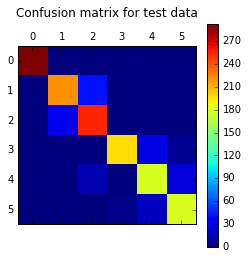

In [12]:
import pylab as pl
pl.matshow(test_cm)
pl.title('Confusion matrix for test data\n'
         + '                               ')
pl.colorbar()
pl.show()

In [13]:
# Accuracy
print("Accuracy = %f" %(skm.accuracy_score(test_truth,test_pred)))

Accuracy = 0.893603


In [14]:
# Precision
print("Precision = %f" %(skm.precision_score(test_truth,test_pred)))

Precision = 0.896920


/home/darth/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [15]:
# F1 Score
print("F1 score = %f" %(skm.f1_score(test_truth,test_pred)))

F1 score = 0.894181


/home/darth/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


References:
https://en.wikipedia.org/wiki/Random_forest
http://learnds.com/
http://nbviewer.jupyter.org/github/agconti/kaggle-titanic/blob/master/Titanic.ipynb